## You can possibly rerun this whole notebook but I have no idea if I reset the random seed before this successful run or not. So I didn't clear the outputs.

### Load files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip drive/MyDrive/train.zip

Archive:  drive/MyDrive/train.zip
  inflating: train.1.h5              
  inflating: train.2.h5              


---

### This part was provided by HTB

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

import torch
from torch import nn
from torchvision import transforms
preprocess = transforms.Compose([
    transforms.Normalize(
        mean=np.array([0.1086, 0.0934, 0.0711]),
        std=np.array([0.1472, 0.123, 0.1032]))
])

import h5py

SEED = 1337
torch.manual_seed(SEED)
np.random.seed(SEED)
torch.use_deterministic_algorithms(True)

from model import StarChartModel, StarData

In [ ]:
with h5py.File("train.1.h5", "r") as F:
    train_images1 = np.array(F["X"])
    train_labels1 = np.array(F["y"])
with h5py.File("train.2.h5", "r") as F:
    train_images2 = np.array(F["X"])
    train_labels2 = np.array(F["y"])
train_images = np.concatenate((train_images1, train_images2))
train_labels = np.concatenate((train_labels1, train_labels2))

In [ ]:
batch_size = 32
train_set = StarData((train_images.transpose(0,3,1,2)/255), train_labels, transform=preprocess)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=batch_size,
    shuffle=True, num_workers=1, pin_memory=True)

In [ ]:
flag = np.zeros((33,33))

I messed around with the dropout rates and the learning rate a lot.

In [ ]:
model = StarChartModel([0.3,0.15])
model.train()

loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 0.0005)

---

### Let's train the network

Looks like input is 3x69x69 and output is 2 (mini batch size is 32)

In [ ]:
losses = []

In [ ]:
n_epochs = 15
for epoch in range(n_epochs):
    counter = 0
    total_loss = 0
    for X_batch, y_batch, aa in train_loader:
        y_pred = model(X_batch)
        loss = loss_func(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        if counter % 30 == 3:
          print(f'{total_loss / counter:.2f} ', end='')
        counter += 1
    loss = total_loss / counter
    losses.append(loss)
    print(f'Epoch {epoch}: {loss}')
    torch.save(model, f'model{epoch:02}.pt')

0.92 0.71 0.69 0.69 0.69 0.68 0.68 0.68 0.67 0.67 0.66 Epoch 0: 0.6509611524261154
0.75 0.56 0.54 0.53 0.52 0.51 0.51 0.51 0.50 0.49 0.49 Epoch 1: 0.4864505327141679
0.61 0.48 0.46 0.46 0.45 0.45 0.45 0.44 0.44 0.44 0.44 Epoch 2: 0.43680423032772075
0.55 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 0.42 Epoch 3: 0.4187092185020447
0.59 0.42 0.41 0.41 0.41 0.41 0.41 0.41 0.41 0.41 0.41 Epoch 4: 0.4085411499212454
0.56 0.40 0.40 0.40 0.40 0.40 0.40 0.40 0.40 0.40 0.40 Epoch 5: 0.3983135642232122
0.55 0.42 0.41 0.41 0.40 0.40 0.40 0.40 0.40 0.40 0.39 Epoch 6: 0.39302727750113775
0.52 0.41 0.40 0.40 0.39 0.39 0.39 0.39 0.39 0.39 0.39 Epoch 7: 0.38886457377367906
0.50 0.39 0.39 0.39 0.39 0.39 0.39 0.39 0.39 0.39 0.39 Epoch 8: 0.38592621379786424
0.54 0.39 0.39 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 Epoch 9: 0.3800247691952072
0.49 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 Epoch 10: 0.3824017789807764
0.46 0.39 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 0.38 Epoch 11: 0.378571249880232

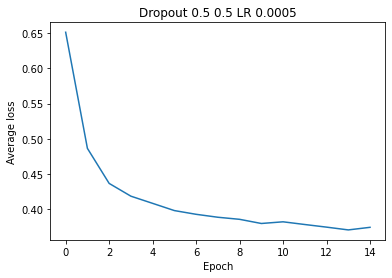

In [ ]:
losses = [float(x) for x in losses]
plt.plot(losses)
plt.title('Dropout 0.5 0.5 LR 0.0005')
plt.xlabel('Epoch')
plt.ylabel('Average loss')
plt.show()

---

### Now let's see if we got anything

In [ ]:
!unzip drive/MyDrive/test.h5.zip

Archive:  drive/MyDrive/test.h5.zip
  inflating: test.h5                 


In [ ]:
with h5py.File("test.h5", "r") as f:
    test_images = np.array(f["X"])

In [ ]:
def get_outputs(model, raw=False):
    output1 = np.zeros((33, 33))
    output2 = np.zeros((33, 33))
    for i in range(33):
        for j in range(33):
            a = test_images[i][j][0]
            a = preprocess(torch.tensor(a.reshape((1, 69, 69, 3)).transpose(0, 3, 1, 2)/255).float())
            output = model(a)
            if raw:
              output1[i, j] = float(output[0][1])
            else:
              output1[i, j] = int(output.argmax())

            a = test_images[i][j][1]
            a = preprocess(torch.tensor(a.reshape((1, 69, 69, 3)).transpose(0, 3, 1, 2)/255).float())
            output = model(a)
            if raw:
              output2[i, j] = float(output[0][1])
            else:
              output2[i, j] = int(output.argmax())

    return output1, output2

In [ ]:
from PIL import Image

In [ ]:
# set_white should return true if that pixel should be set white
def get_qr(set_white, ouput1, output2, name='', show=True):
    mask = Image.open('mask.png').convert('L')
    for i in range(33):
        for j in range(33):
            if mask.getpixel((i, j)) != 0 and mask.getpixel((i, j)) != 255:
                if set_white(output1[i, j], output2[i, j]):
                    mask.putpixel((i, j), 255)
                else:
                    mask.putpixel((i, j), 0)
    if show:
        plt.imshow(mask, cmap='gray')
        plt.show()
        mask.save(name)
    else:
        return mask

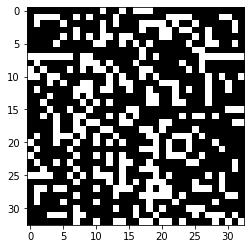

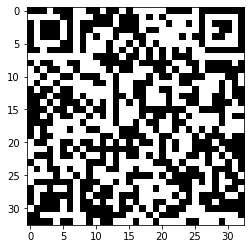

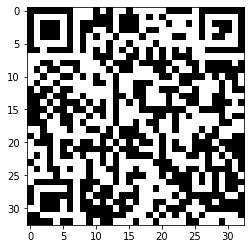

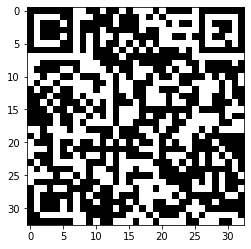

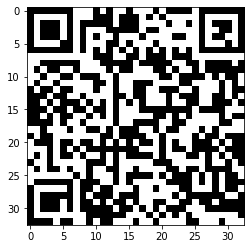

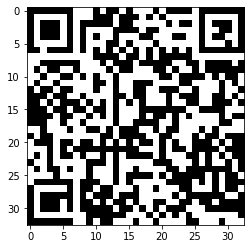

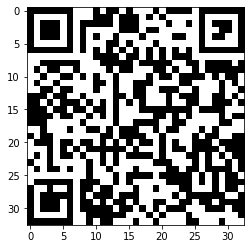

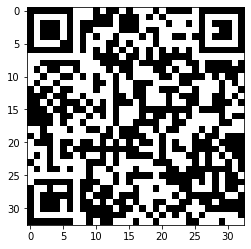

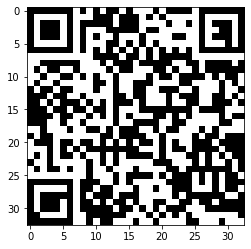

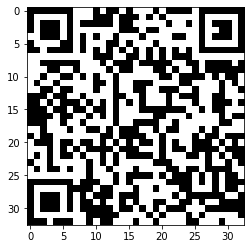

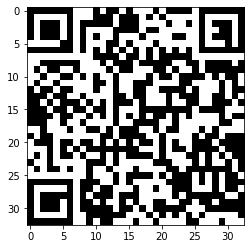

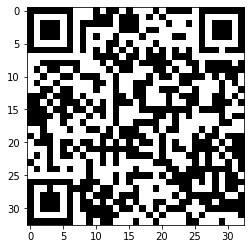

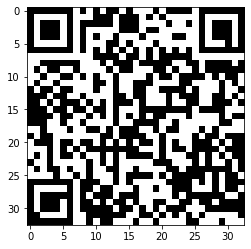

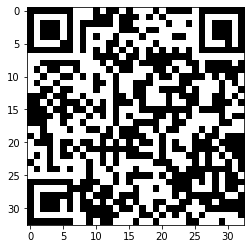

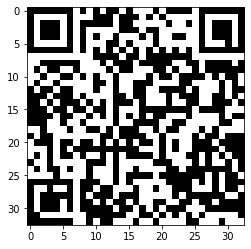

In [29]:
for i in range(n_epochs):
  model = torch.load(f'model{i:02}.pt')
  model.eval()
  output1, output2 = get_outputs(model, raw=True)
  plt.imshow((output1+output2)>1, cmap='gray')
  plt.show()